In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sys
from scipy.stats import entropy
ROOT_DIR = "../"
sys.path.append(ROOT_DIR)
from utils.citymeta import load_all
N = 7 # 13
RES =res = 9 # need to test the 8 later
N_CAT = 27
# prefix = "built_env"
# prefixfull = "_built_environment"
# merge both prefix
prefix_ls = ["_built_environment", ""]

# city_fatality = load_all("fatality_data_source")
# city_fatality = city_fatality[city_fatality['num_person_killed_per_lakh']!=''][['City','Region', 'num_person_killed_per_lakh']]
# city_fatality.shape

# 1. Merge city level all information

In [2]:
# ROOT = "/Users/yuan/Dropbox (Personal)/Personal Work/_Projects2023"
ROOT = "D:/Dropbox (Personal)/Personal Work/_Projects2023"
CURATED_FOLDER = f"{ROOT}/01_city-never-was/_data/_curated/"
EXPORT_FOLDER = f"{ROOT}/01_city-never-was/_data/_curated/c_analysis"
# DATA_FOLDER = f"{CURATED_FOLDER}/c_seg_hex"
DATA_EXPORT = f"{ROOT}/01_city-never-was/_data/_curated/c_hex_cluster"
TRANSFORM_FOLDER = f"{ROOT}/01_city-never-was/_data/_transformed/t_city_profiles"
FILENAME_CROSS = "01_seg_dalys_cross.csv"
y = ['diabetes_mellitus_cap', 'mental_and_substance_use_disorders_cap',
       'cardiovascular_diseases_cap', 'road_injury_cap',
       'road_injury_5-14_cap', 'road_injury_15-29_cap',
       'num_person_killed_per_lakh']

policy_df = pd.read_csv(os.path.join(CURATED_FOLDER, "c_policy.csv"))
gdp = pd.read_csv(os.path.join(CURATED_FOLDER,"c_city_profiles", "c_city_gdp.csv"))
flux = pd.read_csv(os.path.join(TRANSFORM_FOLDER, "t_ffdas_flux_2015.csv"))
gdp['city_lower'] = gdp['City'].apply(lambda x: x.lower().replace(" ", "").split(",")[0])
profiledf = flux.merge(gdp, on = 'city_lower', how = 'inner')
exposure_df = pd.read_csv(os.path.join(EXPORT_FOLDER, "c_exposure_sidewalk_h3.csv"))

waze_df = pd.read_csv(os.path.join(f"{CURATED_FOLDER}/c_waze/","c_waze_accident_alerts_h3_9.csv"))
waze_df_all = pd.read_csv(os.path.join(f"{CURATED_FOLDER}/c_waze/","c_waze_major_accident_h3_9.csv"))\
       .rename(columns = {'major_accident_count':'waze_major_count', 
                          'city':'city_lower',
                          f'h3_{res}':'hex_id'})
waze_df.rename(columns = {'city':'city_lower','h3_9':'hex_id', 'count':'waze_accident_count'}, inplace = True)

waze_count_df = waze_df.groupby('city_lower')['waze_accident_count'].sum().reset_index(name='waze_accident_count')
waze_df_all_count_df = waze_df_all.groupby('city_lower')['waze_major_count'].sum().reset_index(name='waze_major_count')

# waze_count_df
print(profiledf['city_lower'].nunique(), " city profiles found")
# city_meta = load_all()
# tmp solutions here
city_df_basics = pd.read_csv(os.path.join(EXPORT_FOLDER, 
                            f"c_city_full_cluster=8_basics.csv")) # these are the old data
urban_sprawl = pd.read_csv(os.path.join(EXPORT_FOLDER,
                                        'c_urban_sprawl.csv'))
urban_sprawl = urban_sprawl[['city_lower', 'Sprawl_SNDi_’00-13']].reset_index(drop = True).rename(columns = {'Sprawl_SNDi_’00-13':'sprawl_sndi'})
urban_sprawl['city_lower'] = np.where(urban_sprawl['city_lower']=='bogota', 'bogotá', urban_sprawl['city_lower'])
urban_sprawl_2 = pd.read_csv(os.path.join(EXPORT_FOLDER,f'c_road_length_res={res}.csv'))
urban_sprawl_2['city_lower'] = np.where(urban_sprawl_2['city_lower']=='bogotá', 'bogotá', urban_sprawl_2['city_lower'])
# urban_sprawl.head()
urban_sprawl_2_city = urban_sprawl_2.groupby("city_lower")['length_intersection_meter'].mean().reset_index()


exposure_path = f"{ROOT}/01_city-never-was/_data/_curated/c_object_crossectional/exposure_measure/exposure_res={res}.parquet"
exposure_df_2 = pd.read_parquet(exposure_path)
exposure_df_2 = exposure_df_2.fillna(0).rename(columns = {'hex_id_':'hex_id'})

127  city profiles found


In [ ]:
# Load the continent information
city_meta = load_all("select_city_classifier")
region_ls = city_meta[['City','country_clean','Continent']].drop_duplicates().reset_index(drop = True)
region_ls['admin'] = np.where(region_ls['City']=='Hong Kong', 'Hong Kong', region_ls['country_clean'])
region_ls['admin'] = np.where(region_ls['City']=='Taipei', 'Taiwan', region_ls['admin'])
policy_df['admin']= np.where(policy_df['Country']=="United States", "United States of America", policy_df['Country'])
policy_df['admin'] = np.where(policy_df['admin']=="South Korea", "Republic of Korea", policy_df['admin'])
policy_df['admin'] = np.where(policy_df['admin']=="Russia", "Russian Federation", policy_df['admin'])


In [41]:
print(len(set(region_ls['admin'].unique()).intersection(policy_df['Country'].unique())))
# check the remaining countries
assert region_ls[region_ls['admin'].isin(policy_df['admin'])==False].drop_duplicates().reset_index(drop = True).shape[0]==0
assert policy_df[policy_df['admin'].isin(region_ls['admin'])==False].drop_duplicates().reset_index(drop = True).shape[0]==0

48


In [45]:
policy_df['earlier version if any'].unique()

array([1995, 1992, 2002, 1997, 2011, 2001, 2024, 2004, 1996, 1993, 2013,
       1973, 2010, 2005, 1999, 1970, 2009, 2006, 2022, 1983, 1974, 2007,
       2003, 2000, 2015, 1966, 1979, 1998, 1990, 2018, 2016, 1987],
      dtype=int64)

In [48]:
policy_df = policy_df[['admin', 'Policy Name', 'url', 
       'earlier version if any']].reset_index(drop = True)
policy_df['name_cat'] = np.where(policy_df['Policy Name'].str.contains("program", case = False), "program",
                            np.where(policy_df['Policy Name'].str.contains("plan", case = False), "plan",
                            np.where(policy_df['Policy Name'].str.contains("strategy", case = False), "strategy",
                            np.where(policy_df['Policy Name'].str.contains("law", case = False), "law",
                            np.where(policy_df['Policy Name'].str.contains("regulation", case = False), "regulation",
                            np.where(policy_df['Policy Name'].str.contains("guideline", case = False), "guideline",
                            np.where(policy_df['Policy Name'].str.contains("framework", case = False), "framework",
                            np.where(policy_df['Policy Name'].str.contains("initiative", case = False), "initiative",
                                     "other"))))))))
policy_df['version_early_year_cat'] = np.where(policy_df['earlier version if any']<2000, 'before 2000',
                                      np.where(policy_df['earlier version if any']>=2010, 'after 2010', '2000-2010'))

In [49]:
policy_df.groupby(['version_early_year_cat']).size()

version_early_year_cat
2000-2010      14
after 2010     15
before 2000    22
dtype: int64

In [43]:
import gc
gc.collect()

0

In [4]:
# city_df = pd.read_csv(os.path.join(EXPORT_FOLDER, 
#                             f"c_city_full_cluster={N}.csv"))
# city_df_basics = city_df[['center_lat', 'center_lng', 'city_lower', 
#                           'num_person_killed_per_lakh_country',
#                           'num_person_killed_per_lakh_city']]
# city_df_basics.to_csv(os.path.join(EXPORT_FOLDER, 
#                             f"c_city_full_cluster={N}_basics.csv"))
# tmp solutions here
# city_df_basics = pd.read_csv(os.path.join(EXPORT_FOLDER, 
#                             f"c_city_full_cluster={N}_basics.csv"))

### Visualize the country profiles

Text(0.5, 1.0, 'Top 30 cities by total FFDAS flux')

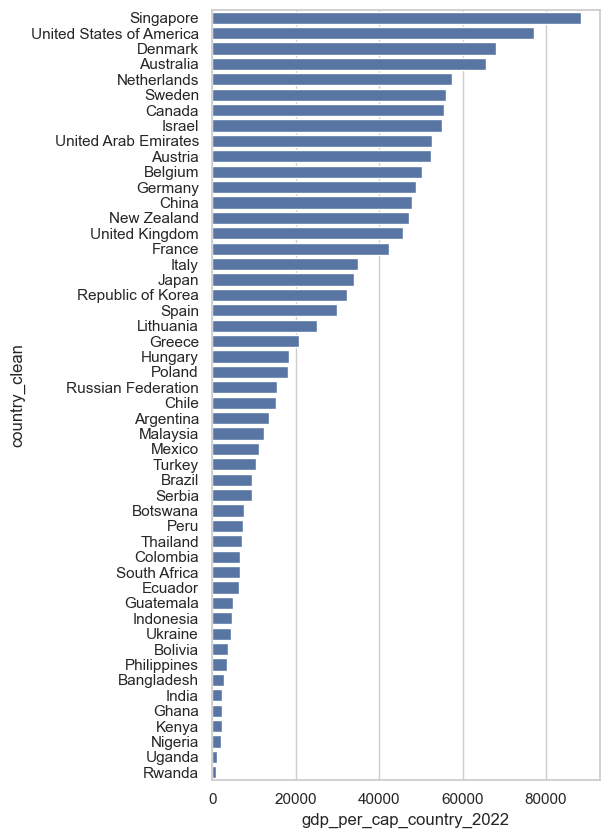

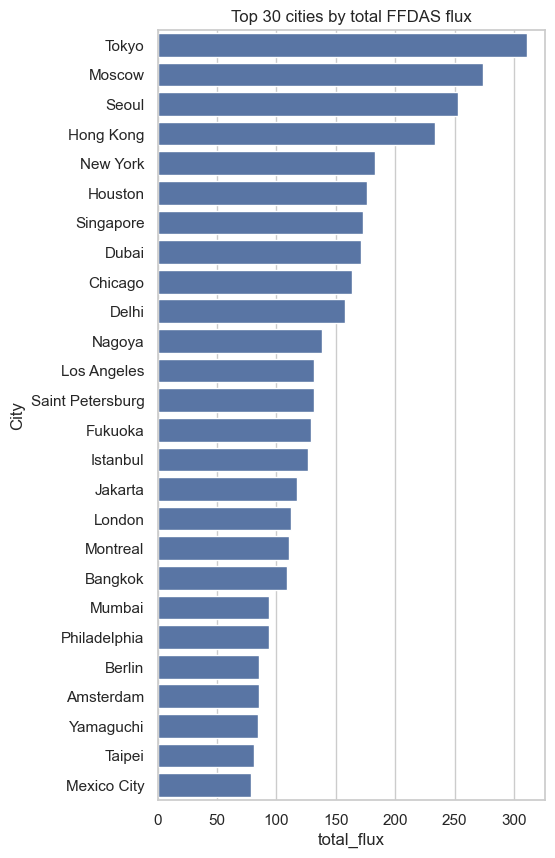

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(5, 10))
sns.barplot(
    data = profiledf.drop_duplicates("country_clean").sort_values('gdp_per_cap_country_2022', ascending = False),
    y = "country_clean",
    x = 'gdp_per_cap_country_2022'
)
fig, ax = plt.subplots(figsize=(5, 10))
sns.barplot(
    data = profiledf.sort_values('total_flux', ascending = False).head(30),
    y = "City",
    x = 'total_flux'
)
# add title
plt.title("Top 30 cities by total FFDAS flux")


In [ ]:


# cluster_df = pd.read_parquet(os.path.join(DATA_FOLDER, f"all_city_within_boundary_res=9_cluster={N}.parquet"))
# withincity = True
def get_cluster_summary(N, prefix):
    cluster_df = pd.read_csv(os.path.join(
        DATA_EXPORT,
        f"allcity{prefix}_cluster={N}_res={RES}.csv")
                             )
    cluster_df['city_lower'] = cluster_df['city_lower'].apply(lambda x: x.lower().replace(" ", "").split(",")[0])
    # cluster_df.head()
    
    cluster_df_summary = cluster_df.groupby(['city_lower',f'cluster_{N}']).size().reset_index(name='count')\
        .pivot(index='city_lower', columns=f'cluster_{N}', values='count').reset_index().fillna(0)
    # convert to wide format
    
    cluster_df_summary['total'] = cluster_df_summary[cluster_df_summary.columns[1:-1]].sum(axis=1)
    for c in cluster_df_summary.columns[1:-1]:
        cluster_df_summary[c] = cluster_df_summary[c]/cluster_df_summary['total']
        cluster_df_summary.rename(columns={c: f"cluster_{c}"}, inplace=True)

    entropy_variables = ['cluster_'+str(i) for i in range(N)]
    cluster_df_summary['diversity'] = \
        cluster_df_summary[entropy_variables].apply(lambda x: entropy(x)/np.log(N), axis = 1)
    return cluster_df, cluster_df_summary

# cluster_df_summary.head()
def get_exposure_summary(cluster_df, exposure_df):
    for c in exposure_df.columns:
        exposure_df[c] = exposure_df[c].fillna(0)
    exposure_df_summary = cluster_df[['hex_id']].merge(exposure_df,
                                                    left_on = "hex_id",
                                                    right_on = "h3_9",
                                                    )\
                                           .merge(exposure_df_2[[
                                               "hex_id",
                                               'person_exposure',
                                               'bicycle_exposure', 
                                               'motorcycle_exposure']],
                                                  right_on = "hex_id",
                                                  left_on = "h3_9",
                                                  )\
        .fillna(0).groupby(['city_lower'])\
        .agg({
            "h3_9":"nunique",
            'img':"sum", 
            'panoid':"sum",
            'sidewalk_presence':"mean", 
            'exposure_presence':"mean",
            'obj_bicycle':"mean",
            'obj_motorcycle':"mean",
            'obj_person':"mean",
            'obj_truck':'mean',
            'obj_car':'mean',
            'obj_bus':'mean',
            "person_exposure":"mean",
            "bicycle_exposure":"mean",
            "motorcycle_exposure":"mean",
            # 'obj_van':'mean',
        }
        ).reset_index().rename(
            columns = {'h3_9':'num_hex','img':'img_count', 'panoid':'panoid_count'}
        )
    return exposure_df_summary

In [20]:
exposure_cols = ['h3_9', 
       'sidewalk_presence', 'exposure_presence', 'obj_bicycle',
       'obj_bus', 'obj_car', 'obj_motorcycle',
       'obj_person',  'obj_train',
       'obj_truck', 
       # 'obj_van',
       'city_lower']

In [21]:
# get hexagon percentage of exposure, sidewalk presence, objects
# N= 7
# cluster_df, cluster_df_summary, y_crossed, crossdf = get_cluster_summary(N, prefixfull)
# exposure_df_summary = get_exposure_summary(cluster_df, exposure_df)

In [22]:
# crossdf = pd.read_csv(os.path.join(CURATED_FOLDER, "c_analysis", FILENAME_CROSS)).drop(["urban_pop"], axis = 1)
# crossdf['city_lower'] = crossdf['city_lower'].apply(lambda x: x.lower().replace(" ", "").split(",")[0])
# crossdf = crossdf[crossdf['res']==9].reset_index(drop = True)
# y_crossed = crossdf[y+['city_lower']].drop_duplicates()
# crossdf.head()

In [23]:
featurecols = ['bike', 'building', 'bus', 'car',
       'grass', 'installation', 'lake+waterboday', 'light', 'mountain+hill',
       'other', 'person', 'pole', 'railing', 'res', 'road', 'shrub',
       'sidewalk', 'signage', 'sky', 'skyscraper', 'sportsfield', 'tower',
       'traffic light', 'trashcan', 'tree', 'truck', 'van', 'window',]
print(len(featurecols), " features found")

28  features found


In [50]:
policy_df.columns

Index(['admin', 'Policy Name', 'url', 'earlier version if any', 'name_cat',
       'version_early_year_cat'],
      dtype='object')

In [51]:
def get_export_for_analysis(N):
       crossdf = pd.read_csv(os.path.join(CURATED_FOLDER, "c_analysis", FILENAME_CROSS)).drop(["urban_pop"], axis = 1)
       crossdf['city_lower'] = crossdf['city_lower'].apply(lambda x: x.lower().replace(" ", "").split(",")[0])
       crossdf = crossdf[crossdf['res']==9].reset_index(drop = True)
       y_crossed = crossdf[y+['city_lower']].drop_duplicates()
       
       # cluster_df, cluster_df_summary = get_cluster_summary(N, prefixfull)
       # for prefix in prefix_ls:
       DATA_FOLDER = f"{CURATED_FOLDER}/c_seg_hex"
       FILENAME_WITHIN = "c_seg_cat={n_cat}_res={res}_withincity{prefixfull}_tsne" # temporary test
       
       import h3
       from haversine import haversine, Unit
       
       for prefix in [
              '_built_environment', 
                      '']:
              cluster_df, cluster_df_summary = get_cluster_summary(N, prefix)
              df_ori_within = pd.read_csv(os.path.join(DATA_FOLDER, 
                                   f"{FILENAME_WITHIN}_cluster_range.csv".format(prefixfull = prefix, res = res, n_cat = N_CAT)))
              df_ori_within_city = df_ori_within[featurecols+['city_lower']].fillna(0).groupby('city_lower')\
                     .mean().reset_index()
              exposure_df_summary = get_exposure_summary(cluster_df, exposure_df)
              city_df = cluster_df_summary.merge(profiledf, on = "city_lower", how = 'left')\
                     .merge(city_df_basics,on = "city_lower", how = 'inner' )\
                                   .merge(y_crossed, on = 'city_lower', how = 'inner', suffixes=('_city', '_country'))\
                                          .merge(waze_count_df, on = 'city_lower',  how = 'left')\
                                                        .merge(exposure_df_summary, 
                                                               on = 'city_lower').drop('Unnamed: 0', axis = 1)\
                                                                      .merge(waze_df_all_count_df, on = 'city_lower', 
                                                                             how = 'left').drop_duplicates("City")\
                                                                                    .reset_index(drop = True)\
                                                                                           .merge(df_ori_within_city, 
                                                                                                  on = 'city_lower', how = 'left')\
                                                                                           .merge(urban_sprawl, on = 'city_lower', how = 'left')\
                                                                                           .merge(urban_sprawl_2_city, on = 'city_lower', how = 'left')\
                                                                                           .merge(region_ls, on = 'country_clean', how = 'left')\
                                                                                           .merge(policy_df[['admin', 
                                                                                                             'name_cat',
                                                                                                                'version_early_year_cat']], on = 'admin', how = 'left')
              # country level merge
              hex_mergedf = cluster_df\
                     .merge(profiledf, on = "city_lower", how = 'left')\
                     .merge(city_df_basics.drop('Unnamed: 0', axis = 1),on = "city_lower", how = 'inner' ).drop("cluster_7", axis = 1)\
                     .merge(df_ori_within, on = ['city_lower', 'hex_id'])\
                     .merge(waze_df, on = ['city_lower', 'hex_id'], 
                            how = 'left')\
                     .merge(waze_df_all, on = ['city_lower', 'hex_id'],
                            how = 'left')\
                     .merge(exposure_df[exposure_cols], right_on = ['city_lower', f'h3_{res}'],
                            left_on = ['city_lower','hex_id']
                            ).drop_duplicates(['city_lower', 'hex_id']).reset_index(drop = True)\
                     .merge(exposure_df_2[[
                                               "hex_id",
                                               'person_exposure',
                                               'bicycle_exposure', 
                                               'motorcycle_exposure']],
                                                  left_on = "hex_id",
                                                  right_on = "hex_id",
                                                  how = 'left'
                                                  )\
                     .merge(urban_sprawl_2, on = ['city_lower', 'hex_id'], how = 'left')\
                            .merge(region_ls, on = 'country_clean', how = 'left')\
                            .merge(policy_df[['admin', 'name_cat','version_early_year_cat']], on = 'admin', how = 'left')
              for c in exposure_cols+['person_exposure', 'bicycle_exposure', 'motorcycle_exposure']:
                     hex_mergedf[c] = hex_mergedf[c].fillna(0)

              hex_mergedf['waze_accident_count'] = hex_mergedf['waze_accident_count'].fillna(0)
              hex_mergedf['waze_total_accident_city'] = hex_mergedf.groupby('city_lower')['waze_accident_count'].transform('sum')
              hex_mergedf['include'] = np.where(hex_mergedf['waze_total_accident_city']>0, 1, 0)

              assert hex_mergedf[hex_mergedf["center_lat"].isna()]['city_lower'].nunique() == 0
              
              hex_mergedf['hex_lat'] = hex_mergedf['hex_id'].apply(lambda x: h3.h3_to_geo(x)[0])
              hex_mergedf['hex_lng'] = hex_mergedf['hex_id'].apply(lambda x: h3.h3_to_geo(x)[1])
              # calculate haversine distance to city center
              
              hex_mergedf['dist_center'] = hex_mergedf.apply(lambda x: haversine((x['center_lat'], x['center_lng']),
                                                        (x['hex_lat'], x['hex_lng']), unit = Unit.METERS), axis = 1)
              hex_mergedf.to_csv(os.path.join(EXPORT_FOLDER,
                                          f"c_hex{prefix}_full_cluster={N}_ncat={N_CAT}.csv"), index = False)
              city_df.to_csv(os.path.join(EXPORT_FOLDER,
                                          f"c_city{prefix}_full_cluster={N}_ncat={N_CAT}.csv"), index = False)
              print(f"Exported {N} clusters for {prefix}")
              print("*"*100)

In [52]:
get_export_for_analysis(N)

TypeError: can only concatenate str (not "float") to str

In [58]:
cluster_df = pd.read_csv(os.path.join(
        DATA_EXPORT,
f"allcity{prefix}_cluster={N}_res={RES}.csv")
                        )
cluster_df['city_lower'] = cluster_df['city_lower'].apply(lambda x: x.lower().replace(" ", "").split(",")[0])
# cluster_df.head()

cluster_df_summary = cluster_df.groupby(['city_lower',f'cluster_{N}']).size().reset_index(name='count')\
.pivot(index='city_lower', columns=f'cluster_{N}', values='count').fillna(0)
# convert to wide format
cluster_df_summary['total'] = cluster_df_summary.sum(axis=1)
for c in cluster_df_summary.columns[:-1]:
    cluster_df_summary[c] = cluster_df_summary[c]/cluster_df_summary['total']
    cluster_df_summary.rename(columns={c: f"cluster_{c}"}, inplace=True)

entropy_variables = ['cluster_'+str(i) for i in range(N)]
cluster_df_summary['diversity'] = \
cluster_df_summary[entropy_variables].apply(lambda x: entropy(x)/np.log(N), axis = 1)

In [59]:
cluster_df_summary

cluster_7,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,total,diversity
city_lower,,,,,,,,,
accra,0.336024,0.025732,0.046922,0.093845,0.093340,0.125631,0.278507,1982.0,0.855238
amsterdam,0.116170,0.097331,0.144427,0.248038,0.181057,0.127682,0.085296,1911.0,0.968326
antwerp,0.266367,0.121309,0.086650,0.191913,0.197047,0.095635,0.041078,1558.0,0.931527
astrakhan,0.387755,0.040816,0.018260,0.066595,0.103115,0.027927,0.355532,931.0,0.746841
athens,0.108108,0.095047,0.087210,0.046619,0.053954,0.140862,0.468201,9953.0,0.826737
...,...,...,...,...,...,...,...,...,...
vijayawada,0.103306,0.061983,0.260331,0.123967,0.028926,0.099174,0.322314,242.0,0.880123
warsaw,0.118152,0.042943,0.200325,0.298747,0.156917,0.104457,0.078459,4308.0,0.923383
wellington,0.142686,0.005995,0.133993,0.218825,0.072242,0.045264,0.380995,3336.0,0.826301


In [26]:
# N = 7
# get_export_for_analysis(N)

In [53]:
prefix = "_built_environment"
city_df = pd.read_csv(os.path.join(EXPORT_FOLDER,
                            f"c_city{prefix}_full_cluster={N}_ncat={N_CAT}.csv"))
city_df[city_df['length_intersection_meter'].isna()]

,city_lower,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,total,diversity,...,tower,traffic light,trashcan,tree,truck,van,window,sprawl_sndi,length_intersection_meter,Continent


In [5]:
prefix = "_built_environment"
hex_path = os.path.join(EXPORT_FOLDER,f"c_hex{prefix}_full_cluster={N}_ncat={N_CAT}.csv")
hex_df = pd.read_csv(hex_path)

C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_40544\3761175985.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  hex_df = pd.read_csv(hex_path)


In [6]:
import h3
hex_df['hex_lat'] = hex_df['hex_id'].apply(lambda x: h3.h3_to_geo(x)[0])
hex_df['hex_lng'] = hex_df['hex_id'].apply(lambda x: h3.h3_to_geo(x)[1])
# calculate haversine distance to city center
from haversine import haversine, Unit
hex_df['dist_center'] = hex_df.apply(lambda x: haversine((x['center_lat'], x['center_lng']),
                                                (x['hex_lat'], x['hex_lng']), unit = Unit.METERS), axis = 1)
# check the distance
hex_df[['city_lower', 'dist_center']].groupby('city_lower')['dist_center'].mean().reset_index().sort_values('dist_center', ascending = False)

,city_lower,dist_center
41,jaipur,31287.911937
55,lagos,22521.994236
40,istanbul,22268.542893
58,losangeles,20737.216683
106,wellington,20135.649047
...,...,...
78,parepare,3514.336148
95,sydney,2884.758674
19,cirebon,2790.758974
88,santiago,2246.075176


In [9]:
# for all hexex, calculate their distance from the city center
hex_df.to_csv(os.path.join(EXPORT_FOLDER, f"c_hex{prefix}_full_cluster={N}_ncat={N_CAT}.csv"), index = False)

<AxesSubplot:xlabel='person_exposure', ylabel='num_person_killed_per_lakh'>

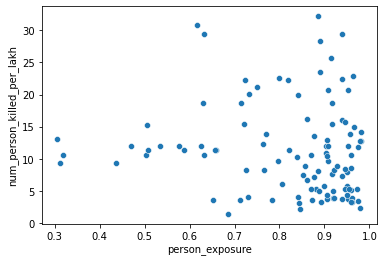

In [41]:
sns.scatterplot(
    data = city_df,
    x = "person_exposure",
    y = 'num_person_killed_per_lakh',
)

In [37]:
city_df.sort_values("motorcycle_exposure", ascending = False).head(20)

,city_lower,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,total,diversity,...,sky,skyscraper,sportsfield,tower,traffic light,trashcan,tree,truck,van,window
15,buenosaires,0.093923,0.278821,0.076611,0.060405,0.006630,0.006998,0.476611,2715.0,0.701877,...,35543.972088,20.158085,184.511273,4.402836,34.764325,64.976997,19641.315581,678.591759,613.606629,8.919980
78,paris,0.068894,0.247390,0.043841,0.115866,0.001044,0.111691,0.411273,958.0,0.788368,...,26105.763667,7.465199,180.462203,6.485133,72.161621,60.723078,20651.367510,474.098118,936.325802,16.737918
68,mumbai,0.026144,0.086601,0.055556,0.674837,0.006536,0.021242,0.129085,612.0,0.571500,...,57244.196005,78.785594,266.307597,20.486837,32.662742,47.761110,47778.027777,3450.561368,1240.851146,41.716545
62,mexicocity,0.086486,0.230888,0.050000,0.128571,0.004826,0.010425,0.488803,5180.0,0.712705,...,39021.107710,5.120358,148.556200,11.131573,16.264151,17.639633,19294.109682,957.471173,480.155117,14.768786
52,kualalumpur,0.263323,0.169279,0.172414,0.192790,0.009404,0.059561,0.133229,638.0,0.900827,...,39708.597211,160.251806,437.567978,22.363730,13.955924,32.760400,23647.205215,395.405603,168.931088,7.162271
61,metromanila,0.038574,0.101048,0.044235,0.398742,0.007338,0.033543,0.376520,4770.0,0.708900,...,39811.085804,32.114697,192.592756,8.918408,8.294555,20.121186,16017.076839,798.971344,611.448602,15.657096
84,riodejaneiro,0.070160,0.244523,0.087330,0.097099,0.020722,0.073416,0.406750,3378.0,0.826412,...,41050.548674,3.861959,263.268920,6.568474,26.635623,19.366434,20812.701468,544.249349,288.910282,6.614170
11,bogotá,0.171205,0.274524,0.072361,0.033943,0.052592,0.017531,0.377844,2681.0,0.799332,...,47672.287931,10.817818,856.546225,6.634189,24.448441,27.179673,9451.997145,901.022225,263.170385,5.244115
33,guatemalacity,0.157337,0.263238,0.071104,0.083207,0.033283,0.030257,0.361573,661.0,0.834619,...,47161.849958,12.020671,315.090297,9.116279,19.175466,10.732980,19407.207327,976.939378,331.995938,22.774912
94,sydney,0.174419,0.426357,0.031008,0.139535,0.000000,0.031008,0.197674,258.0,0.759912,...,35144.924665,58.571683,205.844440,9.614011,81.952494,80.231933,23702.861529,439.742354,437.550617,12.681081


In [36]:
city_df.sort_values("person_exposure", ascending = False).head(20)

,city_lower,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,total,diversity,...,sky,skyscraper,sportsfield,tower,traffic light,trashcan,tree,truck,van,window
32,guadalajara,0.190713,0.399668,0.042289,0.036484,0.003317,0.012438,0.315091,1206.0,0.706360,...,53331.493354,2.090461,147.251448,19.542618,15.449216,16.397226,21366.770916,877.301345,529.528660,21.194787
15,buenosaires,0.093923,0.278821,0.076611,0.060405,0.006630,0.006998,0.476611,2715.0,0.701877,...,35543.972088,20.158085,184.511273,4.402836,34.764325,64.976997,19641.315581,678.591759,613.606629,8.919980
71,newyork,0.265572,0.464165,0.097758,0.027261,0.009233,0.036348,0.099663,6823.0,0.733558,...,43435.806070,21.932166,270.834774,2.660770,57.810393,29.127657,19927.883251,570.497976,522.696256,6.431717
62,mexicocity,0.086486,0.230888,0.050000,0.128571,0.004826,0.010425,0.488803,5180.0,0.712705,...,39021.107710,5.120358,148.556200,11.131573,16.264151,17.639633,19294.109682,957.471173,480.155117,14.768786
12,boston,0.225750,0.358025,0.119929,0.100529,0.008818,0.040564,0.146384,567.0,0.843840,...,42833.517491,25.538125,158.808750,4.944216,79.994941,59.356682,19094.198140,349.220236,371.116138,15.536438
63,miami,0.305195,0.342301,0.117811,0.128942,0.006494,0.043599,0.055659,1078.0,0.809555,...,53556.736966,65.241420,266.434478,4.902870,40.552824,92.558119,20280.161826,240.866243,278.678479,5.742185
100,toronto,0.370166,0.331492,0.051934,0.082873,0.006630,0.013260,0.143646,905.0,0.751936,...,39987.067773,74.177493,208.220539,9.063232,41.174950,83.641790,22319.625291,303.588532,277.967918,7.306347
87,santiago,0.086505,0.397924,0.044983,0.034602,0.000000,0.017301,0.418685,289.0,0.652153,...,54324.597838,35.869741,82.857639,12.108666,77.867345,37.405804,25864.405317,790.401034,770.098687,11.881129
33,guatemalacity,0.157337,0.263238,0.071104,0.083207,0.033283,0.030257,0.361573,661.0,0.834619,...,47161.849958,12.020671,315.090297,9.116279,19.175466,10.732980,19407.207327,976.939378,331.995938,22.774912
44,jerusalem,0.144796,0.342383,0.208145,0.054299,0.125189,0.051282,0.073906,663.0,0.892458,...,51029.436034,5.606471,996.070608,11.064266,36.124495,29.447599,13783.095264,278.832123,304.517677,6.085140


<AxesSubplot:xlabel='waze_accident_count', ylabel='num_person_killed_per_lakh_city'>

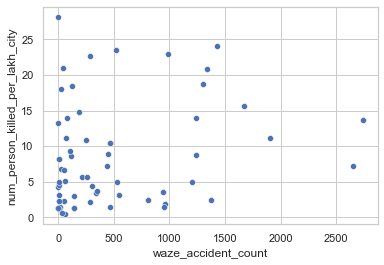

In [101]:
import seaborn as sns
sns.scatterplot(
    data = city_df,
    x = 'waze_accident_count',
    y = 'num_person_killed_per_lakh_city',
)

In [ ]:

# print(hex_mergedf['city_lower'].nunique())
# hex_mergedf.to_csv(os.path.join(EXPORT_FOLDER,
#                             f"c_hex_full_cluster={N}.csv"), index = False)